<h1 style='text-align: center;'>BUDOWA MODELU XGBOOST NA DANYCH BANKOWYCH - CZĘŚĆ II</h1>

Na początku wczytam potrzebne w dalszej części raportu biblioteki oraz dane z części I tego raportu.

In [624]:
import pandas as pd
from IPython.display import display
import warnings
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import shap
from skopt.space import Integer, Real
from skopt import BayesSearchCV
import contextlib
import warnings
import sys
import os

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
        sys.stdout = old_stdout
        sys.stderr = old_stderr

In [626]:
dane=pd.read_csv("C:/Users/ASUS/Desktop/bankowość/lab 2/dane_list2.csv",sep=';')
dane=dane.reset_index()
dane=dane.rename(columns={'index':'customer_id'})
warnings.filterwarnings("ignore", category=FutureWarning)
dane["y"] = dane["y"].replace("yes", 1)
dane["y"] = dane["y"].replace("no", 0)
encoder_dict = {}
dane2 = dane.copy()
encoder = LabelEncoder()
for col in dane2.select_dtypes(include='object').columns:
    dane2[col] = encoder.fit_transform(dane2[col])
    encoder_dict[col] = {i: label for i, label in enumerate(encoder.classes_)}
X_train, X_test, y_train, y_test = train_test_split(dane2[[i for i in dane2.columns if i not in ['y','customer_id']]],
                                               dane2.y,
                                               test_size=0.2,
                                               random_state=20)

## ZBUDOWANIE MODELU XGBOOST NA DOMYŚLNYCH HIPERPARAMETRACH

Stosując polecenie **XGBClassifier()**, utworzę nowy model klasyfikacyjny XGBoost **z domyślnymi parametrami**. Następnie, zastosuję metodę **.fit()**, która służy do trenowania modelu na danych treningowych: X_train i y_train. XGBoost to algorytm oparty na gradientowym boostingu, który iteracyjnie poprawia błędy poprzednich predykcji. Zatem, na początku nastąpi inicjalizacja modelu do klasyfikacji binarnej, a następnie uczenie modelu na danych treningowych poprzez budowanie kolejnych drzew decyzyjnych, optymalizując wagę predykcji.

In [628]:
model1 = xgb.XGBClassifier()
model1.fit(X_train, y_train)

params = model1.get_params()
df_params = pd.DataFrame(params.items(), columns=["Parametr", "Wartość"])
df_params

,Parametr,Wartość
0,objective,binary:logistic
1,use_label_encoder,None
2,base_score,None
3,booster,None
4,callbacks,None
5,colsample_bylevel,None
6,colsample_bynode,None
7,colsample_bytree,None
8,early_stopping_rounds,None
9,enable_categorical,False


Przedstawiona tabela ukazuje wszystkie parametry stworzonego modelu, między innymi:

- **n_estimators = 100** - liczba drzew decyzyjnych w modelu,
- **objective = binary:logistic** - funkcja celu, która jest używana do optymalizacji modelu; model ten jest trenowany w celu przewidywania prawdopodobieństwa przynależności do jednej z dwóch klas,
- **learning_rate** - tempo uczenia modelu,
- **max_depth** - maksymalna głębokość drzewa decyzyjnego.

## SPOSÓB WERYFIKACJI JAKOŚCI BUDOWANYCH MODELI

### MIARA GINI

Aby określić jakość zbudowanego modelu, jednym z najbardziej znanych podejść jest wykorzystanie **miary GINI**. Jest ona ściśle związana z **krzywą ROC** oraz **AUC**, a jej zastosowanie pozwala na uzyskanie intuicyjnego zrozumienia jakości modelu w kontekście rozróżniania dwóch klas.


**Miara GINI** mierzy "czystość" podziałów w klasyfikacji. W kontekście modeli klasyfikacyjnych służy ona do oceny, jak dobrze model jest w stanie rozróżnić klasy. Im wyższa wartość GINI, tym lepsza zdolność modelu do rozróżnienia między klasami. Miara ta jest powiązana z **AUC** - polem pod krzywą ROC - które mierzy ogólną zdolność modelu do rozróżniania między dwiema klasami. Z kolei **krzywa ROC** to krzywa, która przedstawia zależność między **TPR** a **FPR**. **TPR**, czyli czułość, to odsetek prawdziwych pozytywów, które zostały poprawnie sklasyfikowane przez model. Jest to zatem stosunek liczby sytuacji, w których model poprawnie przewidział sukces do liczby wszystkich sytuacji, w których odniesiono sukces. Natomiast **FPR** to odsetek fałszywych pozytywów, które zostały błędnie sklasyfikowane przez model. Jest to zatem stosunek liczby sytuacji, w których model niepoprawnie przewidział sukces do liczby wszystkich sytuacji, w których odniesiono porażkę. W przypadku idealnego klasyfikatora wykres krzywej ROC przechodzi przez lewy górny róg, gdzie $TPR=1$ (idealna czułość), a $FPR=0$ (idealna swoistość).

Aby obliczyć ową miarę GINI, należy zastosować następujący wzór: $$GINI = 2 \cdot AUC - 1.$$ Napiszę zatem funkcję opartą na tym wzorze.

In [630]:
def gini(true_val, predicted_val):
    return 2 * roc_auc_score(true_val, predicted_val) - 1

Wartość GINI wynosząca $1$ oznacza idealny model, a wartość $0$ - model losowy.

Wyliczę teraz wartości GINI dla zbioru treningowego oraz dla zbioru testowego rozważanego modelu o domyślnych hiperparametrach.

In [738]:
def model_summary (model, model_name, opis, df_train, df_test, train_y, test_y):
    gini_train = gini(true_val = train_y, predicted_val = model.predict_proba(df_train)[:,1]) 
    gini_test = gini(true_val = test_y, predicted_val = model.predict_proba(df_test)[:,1])
    df_return = pd.DataFrame({
        'Nazwa modelu': [model_name],
        'Opis': [opis],
        'Liczba zmiennych': [model.n_features_in_],
        'Gini TRAIN': [100*gini_train],
        'Gini TEST': [100*gini_test]
    })
    return df_return  

model_results = model_summary(model1, 'model1', 'model o domyślnych hiperparametrach', X_train, X_test, y_train, y_test)
model_results

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model1,model o domyślnych hiperparametrach,16,96.02407,86.911006


Widzimy, iż dla obu zbiorów uzyskaliśmy **wysokie wartości GINI**, co świadczy o bardzo dobrej zdolności modelu do różnicowania klientów zainteresowanych lokatą od tych, którzy jej nie założą. Wynik GINI bliski $100\%$ oznacza, że model niemal perfekcyjnie rozróżnia pozytywne i negatywne przypadki. Widzimy jednak, że występuje pewna różnica między wynikami dla zbioru treningowego i dla zbioru testowego. Może ona wynikać z  nieoptymalnej konfiguracji parametrów modelu lub też z jego przeuczenia.

**Skąd się bierze GINI?**

W tej części przedstawię **macierz pomyłek**, aby zobrazować skuteczność działania algorytmu klasyfikacyjnego. 

Ustalę na początku próg klasyfikacji (cut-off) na poziomie $0.5$, co oznacza, że jeśli model ocenia, że szansa klienta na zgodę na lokatę jest większa niż $50\%$, to przypisze mu klasę $1$. To najczęściej stosowany punkt odcięcia, ale można go dostosowywać w zależności od zakładanego celu. Na tej podstawie wygeneruję szukaną **macierz pomyłek**.

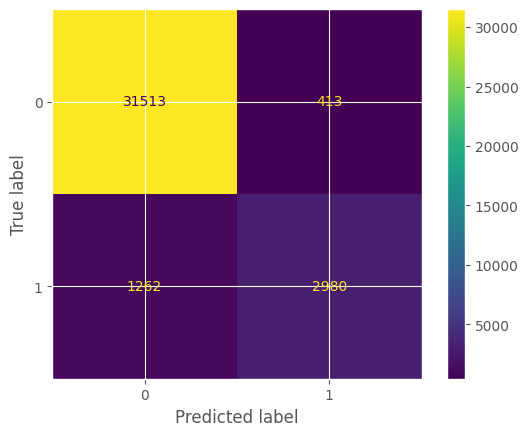

In [634]:
pred_cutoff_50 = pd.Series(model1.predict_proba(X_train)[:,1]).apply(lambda x: 1 if x > 0.5 else 0)
cm = confusion_matrix(y_true = y_train, y_pred = pred_cutoff_50)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model1.classes_)
disp.plot()

Na tej podstawie możemy zauważyć, że $TN = 31513$, co oznacza liczbę sytuacji, w których model poprawnie przewidział, że klient nie założy lokaty. Jest to bardzo wysoka liczba - model dobrze wykrywa klientów niezainteresowanych. Z kolei $TP = 2980$, co oznacza liczbę sytuacji, w których model poprawnie zidentyfikował klientów zainteresowanych lokatą - model skutecznie wskazuje klientów z potencjałem. Natomiast $FP = 413$, co pokazuje liczbę sytuacji, gdy model błędnie przewidział, że klient założy lokatę, a on faktycznie odmówił - jest to niska liczba. Z kolei $FN = 1262$ - liczba sytuacji, w których model nie rozpoznał, że klient jest chętny na założenie lokaty - istotna wartość, co oznacza, że część zainteresowanych klientów została pominięta.

Następnie, przedstawię **wykresy funkcji ROC** zarówno dla zbioru treningowego, jak i dla zbioru testowego. 

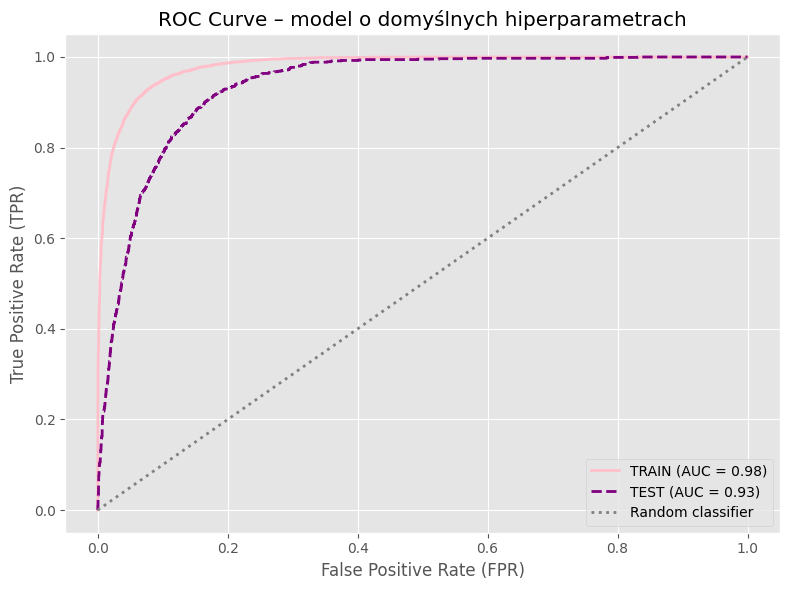

In [636]:
def plot_roc_curve_for_model(model, X_train, y_train, X_test, y_test, model_name):
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    auc_test = auc(fpr_test, tpr_test)

    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='pink', lw=2, label=f'TRAIN (AUC = {auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='purple', lw=2, linestyle='--', label=f'TEST (AUC = {auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle=':', label='Random classifier')

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve – {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc_curve_for_model(model1, X_train, y_train, X_test, y_test, model_name='model o domyślnych hiperparametrach')

Widzimy, iż obie przedstawione wartości AUC są bardzo wysokie, co świadczy o **bardzo dobrej zdolności modelu do rozróżniania klas** (czy klient założy lokatę, czy nie). Dla porównania pokazano także linię klasyfikatora losowego - nasz model istotnie przewyższa ową linię. Możemy jednak zauważyć różnicę między wynikami uzyskanymi dla zbioru treningowego i dla zbioru testowego. Widzimy też, że otrzymane krzywe ROC leżą bardzo blisko lewego górnego rogu, co oznacza, że model osiąga wysokie wartości czułości przy niskiej liczbie fałszywych alarmów.

### MIARY JAKOŚCI ZMIENNYCH

**Feature Importance - GAIN**

**GAIN** mierzy wpływ cechy na redukcję błędu w modelu (średnia wartość GAIN ze wszystkich węzłów, w których występuje zmienna). Jest to miara wpływu danej cechy (zmiennej) na poprawę jakości modelu, którą mierzymy poprzez zmniejszenie funkcji straty - to miara tego, jak istotny jest podział danych (rozgałęzienie drzewa) przy użyciu konkretnej cechy w kontekście poprawy predykcji modelu. Jest on obliczany na poziomie każdego podziału w drzewie decyzyjnym i wskazuje, jak dużą poprawę uzyskujemy, gdy dana cecha zostaje użyta do podziału w tym węźle. **Im wyższy GAIN, tym cecha jest bardziej ważna dla modelu i przyczynia się do lepszych prognoz**.

Przedstawię teraz wykres **znormalizowanej miary ważności cech (feature importance) dla rozważanego modelu opartą na metryce GAIN**.

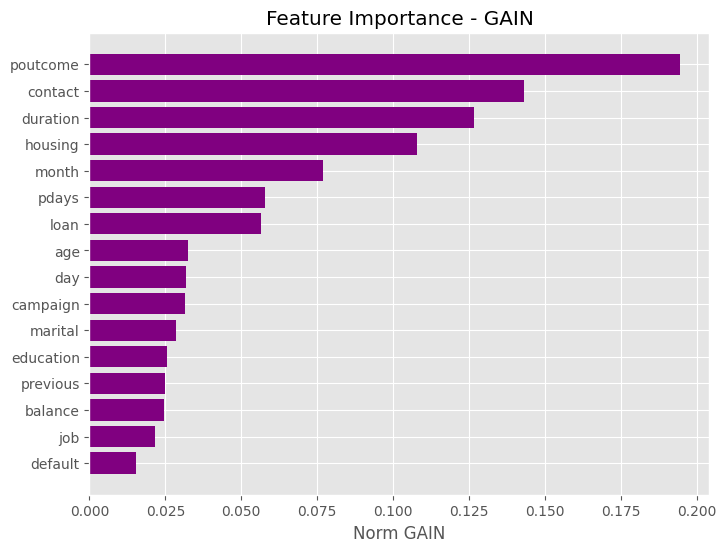

In [638]:
def fi_plot(feat_names, fi_values, title_text, yaxis_text, ax=None):
    df_to_plot = pd.DataFrame({
        'zmienna': feat_names,
        'fi_values': fi_values,
    }).sort_values('fi_values', ascending=True)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.barh(df_to_plot['zmienna'], df_to_plot['fi_values'], color='purple')
    ax.set_title(title_text)
    ax.set_xlabel(yaxis_text)

fi_plot(X_train.columns, model1.feature_importances_, title_text = "Feature Importance - GAIN",
        yaxis_text = 'Norm GAIN')

Widzimy, iż **poutcome** (wynik poprzedniej kampanii) jest zdecydowanie najważniejszą zmienną. Wskazuje to na fakt, iż wynik wcześniejszej kampanii marketingowej silnie koreluje z decyzją o lokacie. Ważnymi zmiennymi są także **contact** (typ kontaktu) oraz **duration** (czas trwania ostatniego kontaktu) - mają one bardzo wysokie znaczenie i są kluczowe w przewidywaniu decyzji klienta. Z kolei najmniej istotne zmienne to **default** (czy zaległości w spłacie kredytu), **job** (rodzaj pracy) i **balance** (średnie roczne saldo na koncie) - mają one najmniejszy wpływ na poprawę jakości modelu, a ich znormalizowana wartość GAIN jest bliska zera. Warto rozważyć usunięcie niektórych z tych zmiennych, jeśli uproszczenie modelu przyniesie lepszą generalizację.

**Permutation Importance**

**Permutation Importance** to miara, która weryfikuje moc modelu w porównaniu do mocy modelu z jedną zmienną, której wartości zostały poddane permutacji. **Zmienna, dla której moc modelu osiągnie największy spadek jest uznawana za najlepszą**. To metoda oceny znaczenia zmiennych (cech) w modelu predykcyjnym, polegająca na mierzeniu wpływu losowego przetasowania wartości danej cechy na jakość działania modelu. W przeciwieństwie do GAIN (który jest oparty na strukturze drzewa), Permutation Importance mierzy realny wpływ cechy na jakość predykcji, przez co często daje bardziej praktyczny obraz rzeczywistej przydatności zmiennych. 

Przedstawię teraz omawianą miarę na wykresach zarówno dla zbioru treningowego, jak i dla zbioru testowego dla rozważanego modelu o domyślnych parametrach.

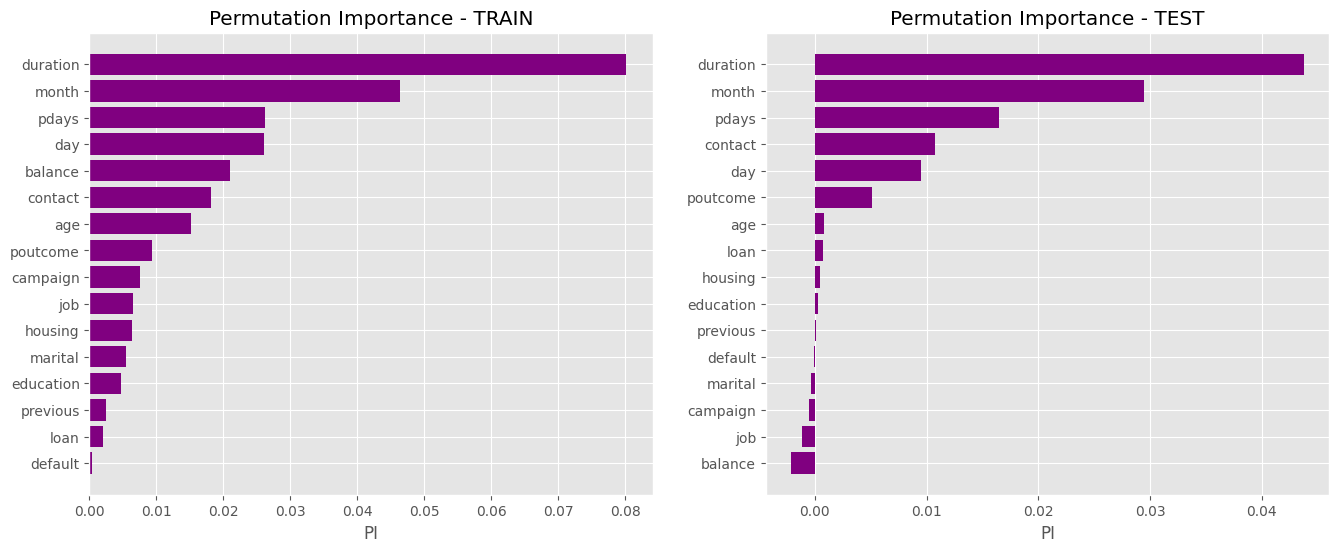

In [640]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
pi_results_train = permutation_importance(model1, X_train, y_train, n_repeats = 10, random_state = 0).importances_mean
pi_results_test = permutation_importance(model1, X_test, y_test, n_repeats = 10, random_state = 0).importances_mean

fi_plot(X_train.columns, pi_results_train, title_text = "Permutation Importance - TRAIN",
        yaxis_text = 'PI', ax = ax1)
fi_plot(X_train.columns, pi_results_test, title_text = "Permutation Importance - TEST",
        yaxis_text = 'PI', ax = ax2)

Na lewym wykresie widzimy, iż na podstawie tej miary zdecydowanie najważniejszą zmienną jest **duration** (czas trwania ostatniego kontaktu) - jej permutacja najbardziej pogarsza wynik modelu. Istotnymi zmiennymi są tutaj również **month** (miesiąc ostatniego kontaktu), **pdays** (liczba dni od ostatniego kontaktu) oraz **day** (dzień ostatniego kontaktu). Z kolei najmniejsze znaczenie zdecydowanie osiąga zmienna **default** (czy zaległości w spłacie kredytu) - możliwe, iż jest to zmienna zbędna. Widzimy ponadto, że dla rozważanych zbiorów treningowego i testowego uzyskane wyniki różnią się od siebie w pewnym stopniu, co może wskazywać na niską stabilność cech lub przeuczenie.

**SHAP**

**SHAP** to metoda wyjaśniania predykcji modelu oparta na teorii gier kooperacyjnych. Przypisuje ona udział każdej zmiennej (cechy) w końcowej decyzji modelu w sposób sprawiedliwy i interpretowalny. Bazuje ona na koncepcji wartości Shapleya z teorii gier, czyli określaniu, jak bardzo gracz (cecha) przyczynia się do wyniku gry (predykcji modelu). SHAP oblicza wpływ każdej zmiennej na różnicę między wartością bazową a wartością przewidywaną dla konkretnej obserwacji.

Przedstawię teraz owe wykresy zarówno dla zbioru treningowego, jak i dla zbioru testowego rozważanego modelu o domyślnych parametrach.

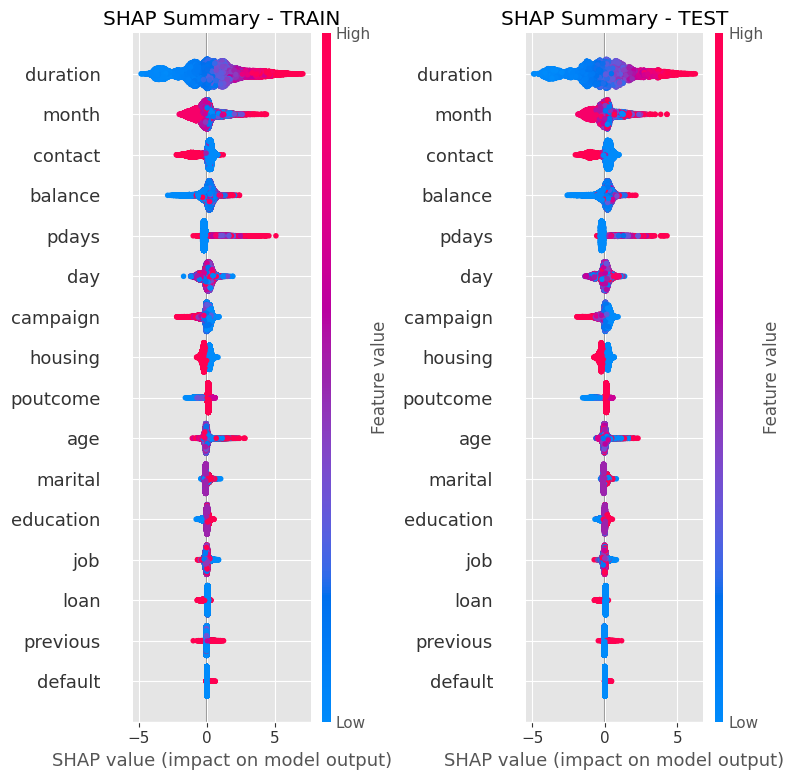

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

with suppress_output():
    plt.sca(ax1)
    explainer = shap.TreeExplainer(model1, X_train)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, show=False)
    ax1.set_title('SHAP Summary - TRAIN')
    
    plt.sca(ax2)
    explainer2 = shap.TreeExplainer(model1, X_test)
    shap_values2 = explainer2.shap_values(X_test)
    shap.summary_plot(shap_values2, X_test, show=False)
    ax2.set_title('SHAP Summary - TEST')
    
    plt.tight_layout()
    plt.show()

Widzimy, iż w obu zbiorach model bazuje na tych samych, najważniejszych cechach: **duration** (czas trwania ostatniego kontaktu), **month** (miesiąc ostatniego kontaktu) i **contact** (typ kontaktu). Oznacza to, że model stabilnie identyfikuje istotne cechy. Zmienna **duration** ma największy wpływ - klienci, z którymi rozmowa trwała długo, są znacznie bardziej skłonni do pozytywnej decyzji, z kolei krótkie rozmowy obniżają szanse na powodzenie. Są też cechy, dla których zależność jest odwrotna - na przykład zmienna **campaign** (liczba kontaktów w tej kampanii) - im mniej owych kontaktów, tym większa szansa na powodzenie. Możemy także zauważyć, że zmienne **default** (czy zaległości w spłacie kredytu), **previous** (liczba kontaktów przed kampanią) i **loan** (czy kredyt gotówkowy) mają wpływ SHAP bliski zeru - może to oznaczać, że są one praktycznie nieistotne. Widzimy ponadto, że model zachowuje podobną strukturę wpływu cech w obu zbiorach, co może wskazywać na dobrą generalizację.

## OPTYMALIZACJA HIPERPARAMETRÓW - BayesSearchCV

W tej części owego raportu przeprowadzę **optymalizację hiperparametrów** za pomocą **optymalizacji Bayesa**. **Optymalizacja bayesowska** to technika pozwalająca na efektywne znalezienie optymalnych parametrów systemu. Łączy pomysły z algorytmów prawdopodobieństwa Bayesa i optymalizacji w celu zbadania przestrzeni wejściowej funkcji celu i zapewnienia najbardziej prawdopodobnych optymalnych parametrów modelu. Różni się od tradycyjnych podejść optymalizacyjnych tym, że nie przeszukuje całej przestrzeni wejściowej, ale raczej skupia się na bardziej ograniczonym podzbiorze, który z większym prawdopodobieństwem da maksimum.

W tym celu zdefiniuję siatkę hiperparametrów - zakresy wartości dla wybranych hiperparametrów. Następnie, przeprowadzę optymalizację, używając metryki *roc_auc* do oceny wydajności modelu z potrójną walidacją krzyżową oraz ograniczając liczbę iteracji do 50.

Metoda ta:
* dopasowuje model XGBClassifier wielokrotnie do różnych zestawów parametrów,
* dla każdego zestawu przeprowadza walidację krzyżową (tu: 3-krotną),
* mierzy wynik (scoring) i zapamiętuje najlepszą konfigurację.

In [643]:
model3 = xgb.XGBClassifier()

# definicja siatki hiperparametrów
param_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(3,10),
    'min_child_weight': Integer(1,200),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'gamma': Real(1e-4, 10, prior='log-uniform'),
    'reg_lambda': Real(1e-4, 10, prior='log-uniform'),
    'reg_alpha': Real(1e-4, 10, prior='log-uniform'),
}

# GridSearchCV
grid_search1 = BayesSearchCV(
    estimator=model3,
    search_spaces=param_space,
    scoring='roc_auc',
    n_iter=50,     # liczba iteracji optymalizacji
    cv=3,
    verbose=3,
    random_state=42
)


with suppress_output():
    grid_search1.fit(X_train, y_train)

Obliczę teraz wartości GINI dla zbudowanego modelu ze zoptymalizowanymi hiperparametrami zarówno dla zbioru treningowego, jak i dla zbioru testowego. Wyniki przedstawię w łączonej tabeli.

In [740]:
model_results = pd.concat([model_results,
                           model_summary(grid_search1.best_estimator_, 'model3', 
                                         'model ze zoptymalizowanymi parametrami dla standardowego zbioru treningowego',
                                         X_train, X_test, y_train, y_test)])

pd.set_option('display.max_colwidth', None) 
model_results

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model1,model o domyślnych hiperparametrach,16,96.024070,86.911006
0,model3,model ze zoptymalizowanymi parametrami dla standardowego zbioru treningowego,16,93.269554,87.855102


Widzimy, iż model o domyślnych parametrach osiągnął lepszy wynik GINI na zbiorze treningowym, co sugeruje, że model ten jest lepiej dopasowany do danych treningowych. Jednakże, wynik ten może wskazywać na przeuczenie tego modelu, gdyż uzyskuje on znacznie wyższy wynik na zbiorze treningowym - może on nie generalizować dobrze na nowe dane. Ponadto, możemy zauważyć, iż to model po optymalizacji hiperparametrów osiągnął wyższy wynik GINI na zbiorze testowym - to ten model lepiej generalizuje na dane testowe. Może to wskazywać na fakt, że optymalizacja hiperparametrów pomogła modelowi3 uzyskać lepszą równowagę między dopasowaniem do danych treningowych a zdolnością do generalizacji na nowych danych. Można zatem stwierdzić, że **model3 jest lepszym modelem**, gdyż lepiej radzi on sobie z nowymi danymi.

Przedstawię teraz wykresy znormalizowanej miary ważności cech opartej na metryce GAIN oraz Permutation Importance dla modelu ze zoptymalizowanymi hiperparametrami na zbiorze treningowym.

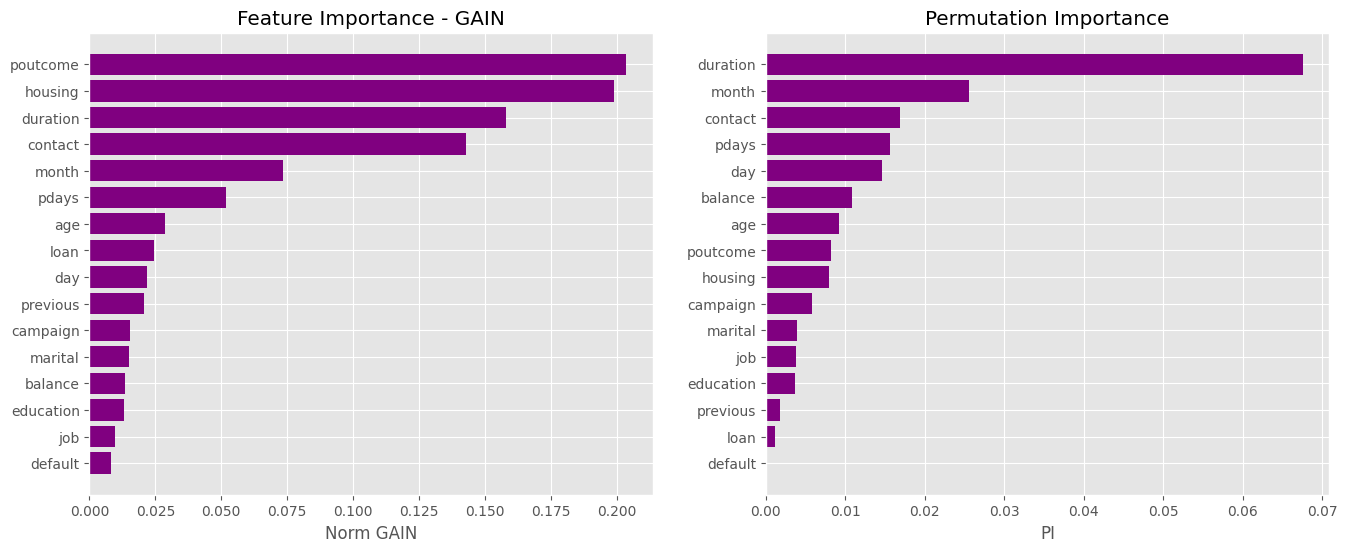

In [653]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fi_plot(X_train.columns, grid_search1.best_estimator_.feature_importances_, title_text = "Feature Importance - GAIN",
        yaxis_text = 'Norm GAIN', ax = ax1)
pi_results_train = permutation_importance(grid_search1.best_estimator_, X_train, y_train, n_repeats = 10, random_state = 0).importances_mean
fi_plot(X_train.columns, pi_results_train, title_text = "Permutation Importance",
        yaxis_text = 'PI', ax = ax2)

Widzimy, iż obie miary wskazują na to, że zmienna **duration** (czas trwania ostatniego kontaktu) ma bardzo duże znaczenie. Z drugiej strony owe wykresy pokazują, że cecha **default** (czy zaległości w spłacie kredytu) jest najmniej ważna.

## WERYFIKACJA WPŁYWU UŻYCIA ZMIENNYCH TYPU DUMMY 

W tej części zweryfikuję wpływ użycia **zmiennych typu dummy** (0-1) na wyniki modelu (o domyślnych hiperparametrach). **Zmienne typu dummy** (zmienne zero-jedynkowe) to sposób reprezentowania **zmiennych kategorycznych** w modelach uczących się na danych liczbowych. Metoda taka może doprowadzić do poprawy jakości predykcji poprzez umożliwienie modelowi wyłapania zależności między konkretnymi kategoriami a zmienną docelową.


Na początku przekształcę zatem zmienne kategoryczne na zmienne typu dummy, a następnie usunę po jednej kategorii z każdej przekształconej zmiennej, aby uniknąć idealnej współliniowości między kolumnami. Dalej, przygotuję dane treningowe i testowe oraz wytrenuję model na owych przekształconych danych.

In [655]:
dane3 = pd.get_dummies(dane[[i for i in dane.columns if i != 'y' and i != 'customer_id']])

# usuwamy po jednej z kategorii dla każdej ze zmiennych, żeby nie było idealnej zależności
dane3 = dane3.drop(columns=['job_admin.', 'marital_divorced', 'education_primary', 'default_no',
                            'housing_no', 'loan_no', 'contact_cellular', 'month_apr', 'poutcome_failure'])

X_train_d = dane3.iloc[X_train.index, :].copy()
X_test_d = dane3.iloc[X_test.index, :].copy()

model2 = xgb.XGBClassifier()
model2.fit(X_train_d, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Obliczę teraz wartości GINI dla zbudowanego modelu na domyślnych hiperparametrach ze zmiennymi dummy zarówno dla zbioru treningowego, jak i dla zbioru testowego. Wyniki przedstawię w łączonej tabeli.

In [742]:
model_results = pd.concat([model_results,
                           model_summary(model2, 'model2', 
                                         'model na domyślnych hiperparametrach ze zmiennymi dummy',
                                         X_train_d, X_test_d, y_train, y_test)])

pd.set_option('display.max_colwidth', None) 
model_results

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model1,model o domyślnych hiperparametrach,16,96.024070,86.911006
0,model3,model ze zoptymalizowanymi parametrami dla standardowego zbioru treningowego,16,93.269554,87.855102
0,model2,model na domyślnych hiperparametrach ze zmiennymi dummy,42,95.659106,87.722538


Widzimy, iż utworzony właśnie model uzyskał wyższą wartość GINI dla zbioru testowego oraz trochę niższą wartość dla zbioru treningowego niż w modelu o domyślnych hiperparametrach. Oznacza to, że zastosowanie zmiennych typu dummy poprawiło zdolność predykcyjną modelu. Możemy także zauważyć, że liczba zmiennych w owym modelu wzrosła do 42, co jest efektem zakodowania zmiennych kategorycznych jako zmienne dummy. Zatem, **lepszym od modelu1 okazał się model2** - model na domyślnych hiperparametrach ze zmiennymi dummy, gdyż osiąga on wyższy wynik GINI na zbiorze testowym, co wskazuje na jego lepszą generalizację i skuteczność predykcji.

Przedstawię teraz wykresy znormalizowanej miary ważności cech opartej na metryce GAIN oraz Permutation Importance dla modelu na domyślnych hiperparametrach ze zmiennymi dummy na zbiorze treningowym.

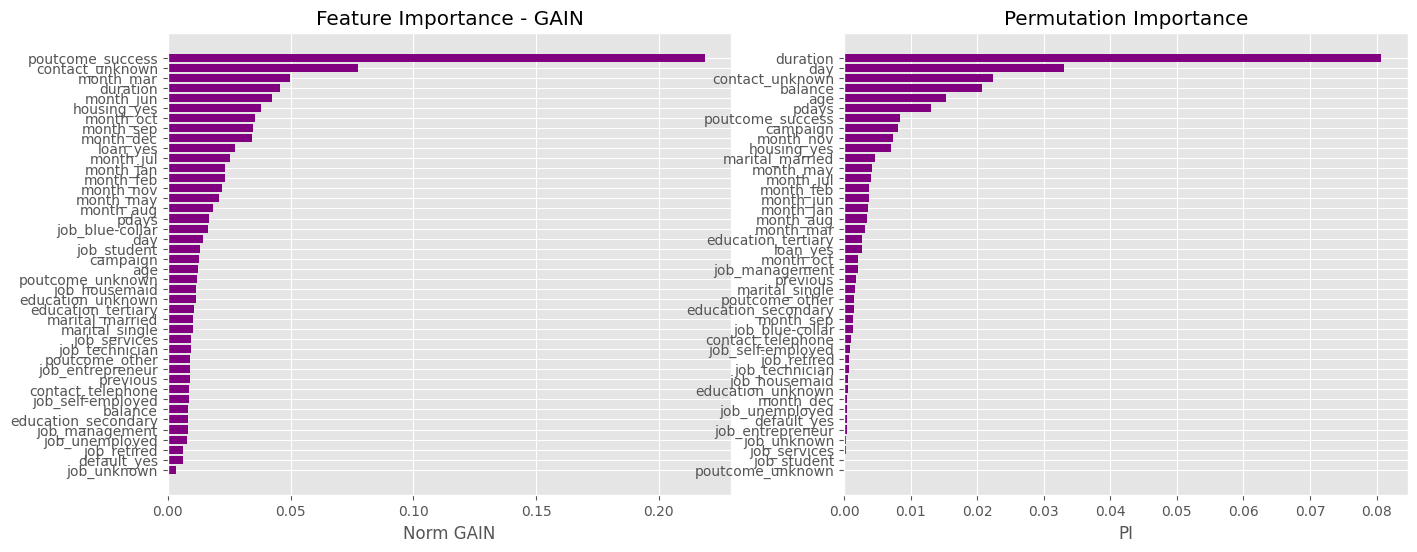

In [660]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fi_plot(X_train_d.columns, model2.feature_importances_, title_text = "Feature Importance - GAIN",
        yaxis_text = 'Norm GAIN', ax = ax1)
pi_results_train = permutation_importance(model2, X_train_d, y_train, n_repeats = 10, random_state = 0).importances_mean
fi_plot(X_train_d.columns, pi_results_train, title_text = "Permutation Importance",
        yaxis_text = 'PI', ax = ax2)

Widzimy, iż wykresy te są mało czytelne, ponieważ model ma aż 42 zmienne. Możemy jednak zauważyć, że, ponownie, zmienna **duration** (czas trwania ostatniego kontaktu) okazuje się być jedną z najważniejszych. 

## OPTYMALIZACJA MODELU BayesSearchCV + ZMIENNE TYPU DUMMY

W tej części utworzę model4 - różni się on od poprzednich tym, że:
* korzysta z danych, w których zmienne kategoryczne zostały zakodowane jako **zmienne typu dummy**,
* poddawany jest **optymalizacji hiperparametrów** przy użyciu metody BayesSearchCV.

Utworzę w ten sposób owy model, a następnie obliczę dla niego wartości GINI zarówno dla zbioru treningowego, jak i dla zbioru testowego. Wyniki przedstawię w łączonej tabeli.

In [662]:
model4 = xgb.XGBClassifier()

grid_search2 = BayesSearchCV(
    estimator=model4,
    search_spaces=param_space,
    scoring='roc_auc',
    n_iter=50,     # liczba iteracji optymalizacji
    cv=3,
    verbose=3,
    random_state=42
)

with suppress_output():
    grid_search2.fit(X_train_d, y_train)

In [744]:
model_results = pd.concat([model_results,
                           model_summary(grid_search2.best_estimator_, 'model4', 
                                         'model ze zoptymalizowanymi parametrami dla zmiennych dummy',
                                         X_train_d, X_test_d, y_train, y_test)])

pd.set_option('display.max_colwidth', None) 
model_results

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model1,model o domyślnych hiperparametrach,16,96.024070,86.911006
0,model3,model ze zoptymalizowanymi parametrami dla standardowego zbioru treningowego,16,93.269554,87.855102
0,model2,model na domyślnych hiperparametrach ze zmiennymi dummy,42,95.659106,87.722538
0,model4,model ze zoptymalizowanymi parametrami dla zmiennych dummy,42,91.090316,87.983486


Mimo to, iż utworzony właśnie model4 osiąga najniższą watość GINI dla zbioru treningowego, to najlepiej radzi on sobie z nowymi, niewidzianymi wcześniej danymi - najwyższa wartość GINI dla zbioru testowego. Właśnie model ze zoptymalizowanymi hiperparametrami dla zmiennych typu dummy charakteryzuje się najlepszą równowagą między uczeniem a generalizacją (brak przeuczenia), co czyni go najbardziej niezawodnym. W modelu tym obserwujemy mniejszą różnicę między GINI dla obu rozważanych zbiorów, co sugeruje lepsze dopasowanie bez nadmiernego uczenia się.  Wprowadzenie zmiennych typu dummy pozwoliło na lepsze uchwycenie informacji zawartych w zmiennych kategorycznych, a dodatkowa optymalizacja hiperparametrów poprawiła jakość klasyfikatora. Zatem, to **model4 jest najlepszy spośród wszystkich rozważanych wcześniej modeli**.

Przedstawię teraz wykresy znormalizowanej miary ważności cech opartej na metryce GAIN oraz Permutation Importance dla modelu ze zoptymalizowanymi hiperparametrami dla zmiennych dummy na zbiorze treningowym.

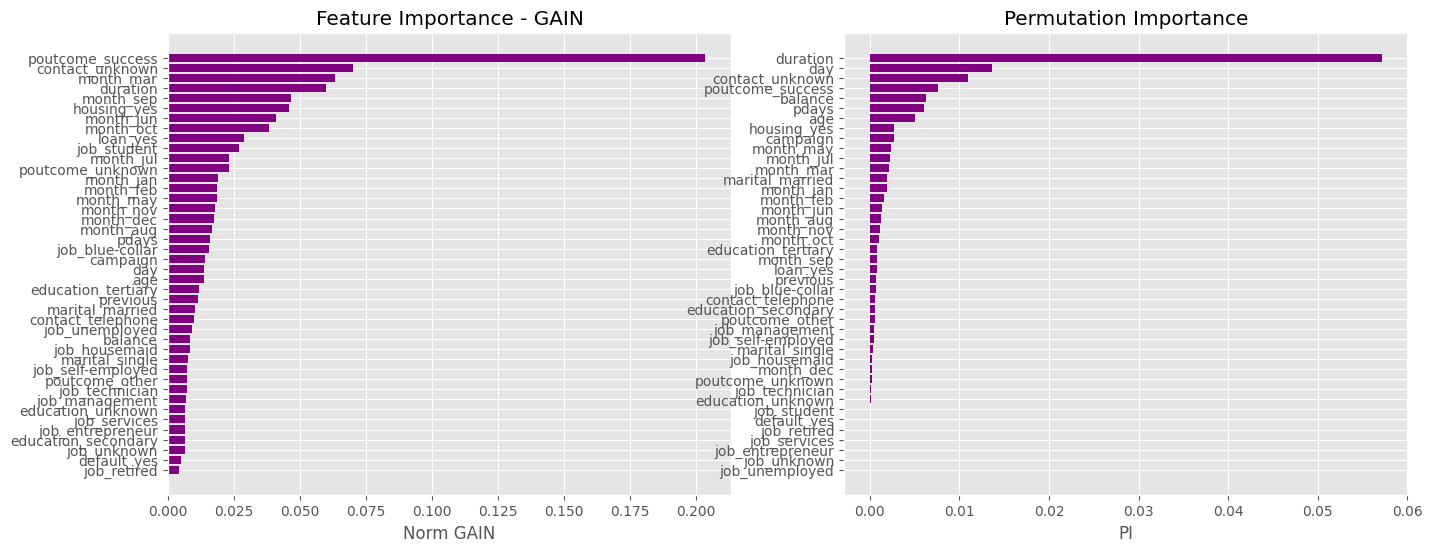

In [666]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fi_plot(X_train_d.columns, grid_search2.best_estimator_.feature_importances_, title_text = "Feature Importance - GAIN",
        yaxis_text = 'Norm GAIN', ax = ax1)
pi_results_train = permutation_importance(grid_search2.best_estimator_, X_train_d, y_train, n_repeats = 10, random_state = 0).importances_mean
fi_plot(X_train_d.columns, pi_results_train, title_text = "Permutation Importance",
        yaxis_text = 'PI', ax = ax2)

Ponownie, uzyskane wykresy są mało czytelne, gdyż rozważany model posiada aż 42 zmienne. Widzimy jednak, że nadal zmienna **duration** (czas trwania ostatniego kontaktu) jest jedną z najważniejszych cech. Możemy również zauważyć, że wpływ wielu ze zmiennych jest niewielki, co może wskazywać, że lepiej byłoby rozważyć model bez owych zmiennych, aby zredukować nadmierny szum. 

## OPTYMALIZACJA LICZBY ZMIENNYCH WYKORZYSTANYCH W MODELU

W tej części raportu przeprowadzę **optymalizację liczby zmiennych wykorzystanych w modelu4** - modelu ze zoptymalizowanymi hiperparametrami dla zmiennych typu dummy. Zweryfikuję wpływ wykluczenia najmniej istotnych zmiennych na moc predykcyjną - przygotuję wykres, na którym przedstawiony będzie przyrost mocy GINI po uwzględnieniu w modelu kolejnych zmiennych od najsilniejszej do najsłabszej na zbiorze treningowym. Na tej podstawie stwierdzę, czy wykluczenie danych zmiennych jest sensowne.

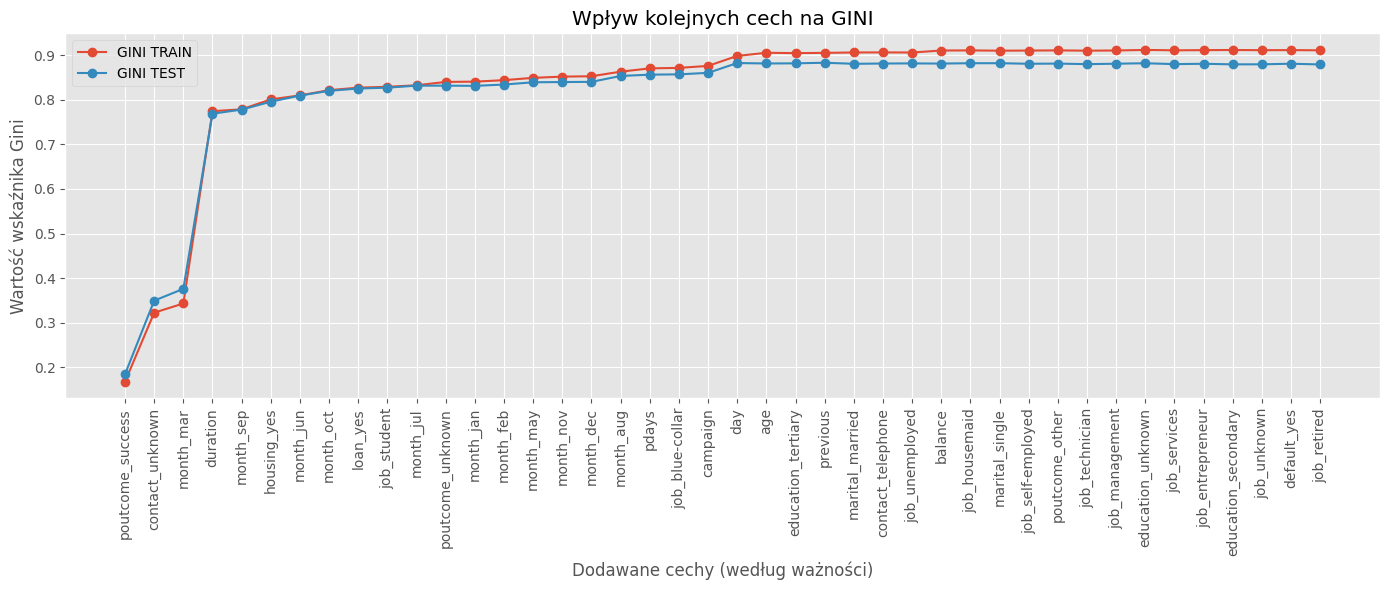

In [670]:
def gini_per_feat(model, df_train, train_y, df_test, test_y, print_df_results=False, params=None):
    df_istotnosc = pd.DataFrame({
        'features': df_train.columns,
        'feature_importance': model.feature_importances_
    }).sort_values('feature_importance', ascending=False).reset_index(drop=True)


    df_istotnosc["GINI train"] = 0.0
    df_istotnosc["GINI test"] = 0.0

    feats = []


    for i in range(df_train.shape[1]):
        feats.append(df_istotnosc.loc[i, 'features'])

        if params is None:
            model_new = xgb.XGBClassifier()
        else:
            model_new = xgb.XGBClassifier(**params)

        model_new.fit(df_train[feats], train_y)

        gini_train = gini(train_y, model_new.predict_proba(df_train[feats])[:, 1])
        gini_test = gini(test_y, model_new.predict_proba(df_test[feats])[:, 1])

        df_istotnosc.loc[i, "GINI train"] = gini_train
        df_istotnosc.loc[i, "GINI test"] = gini_test

        if print_df_results:
            display(df_istotnosc)

    plt.figure(figsize=(14, 6))
    plt.plot(range(len(df_istotnosc)), df_istotnosc["GINI train"], marker='o', label='GINI TRAIN')
    plt.plot(range(len(df_istotnosc)), df_istotnosc["GINI test"], marker='o', label='GINI TEST')
    plt.xticks(ticks=range(len(df_istotnosc)), labels=df_istotnosc["features"], rotation=90)
    plt.xlabel("Dodawane cechy (według ważności)")
    plt.ylabel("Wartość wskaźnika Gini")
    plt.title("Wpływ kolejnych cech na GINI")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_istotnosc
        
tabela = gini_per_feat(
    model=grid_search2.best_estimator_,
    df_train=X_train_d,
    train_y=y_train,
    df_test=X_test_d,
    test_y=y_test,
    print_df_results=False,
    params=grid_search2.best_params_ 
)       

Na osi poziomej widzimy dodawane cechy uporządkowane według ich ważności dla modelu, a na osi pionowej - wartość wskaźnika GINI, która rośnie w miarę dodawania kolejnych zmiennych. Wykres ten pokazuje, jak dodanie każdej kolejnej zmiennej wpływa na skuteczność modelu. Możemy stwierdzić, że **usunięcie z modelu4 zmiennych od *age* do *job_retired* może okazać się sensowne**, gdyż od dodania zmiennej *age* wartość wskaźnika GINI praktycznie przestaje rosnąć, a różnice między wartościami dla zbiorów treningowego i testowego stają się coraz większe. Wskazuje to, że zmienne te mają niewielki wpływ na poprawę jakości modelu. Jest to ważne działanie, gdyż utrzymywanie zmiennych, które nie poprawiają istotnie skuteczności modelu, prowadzi do niepotrzebnego zwiększenia jego złożoności, co utrudnia interpretację, zwiększa ryzyko nadmiernego dopasowania i obciąża owy model.

Utworzę zatem model w omówiony powyżej sposób. Poza wcześniej wskazanymi zmiennymi, usunę też cechy: *puotcome_unknown*, *job_student* i *job_blue-collar*, gdyż z późniejszej analizy wynikało, że nie wnoszą one istotnych informacji. Następnie, obliczę dla tego modelu wartości GINI zarówno dla zbioru treningowego, jak i dla zbioru testowego. Wyniki przedstawię w łączonej tabeli.

In [747]:
cechy_do_usuniecia = [
"poutcome_unknown", "job_student", "job_blue-collar", "job_retired", "default_yes", "job_unknown", "education_secondary", "job_entrepreneur", "job_services", "education_unknown", 
    "job_management", "job_technician", "poutcome_other", "job_self-employed", "marital_single", "job_housemaid", "balance", 
    "job_unemployed", "contact_telephone", "marital_married", "previous", "education_tertiary", "age"

]

char_final = [col for col in X_train_d.columns if col not in cechy_do_usuniecia]
X_train_cham = X_train_d[char_final].copy()
X_test_cham = X_test_d[char_final].copy()

model_cham = xgb.XGBClassifier()
model_cham.fit(X_train_cham, y_train)

model_results = pd.concat([model_results,
                           model_summary(model_cham, 'model_cham', 
                                         'model z usuniętymi zmiennymi',
                                         X_train_cham, X_test_cham, y_train, y_test)])

pd.set_option('display.max_colwidth', None) 
model_results

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model1,model o domyślnych hiperparametrach,16,96.024070,86.911006
0,model3,model ze zoptymalizowanymi parametrami dla standardowego zbioru treningowego,16,93.269554,87.855102
0,model2,model na domyślnych hiperparametrach ze zmiennymi dummy,42,95.659106,87.722538
0,model4,model ze zoptymalizowanymi parametrami dla zmiennych dummy,42,91.090316,87.983486
0,model_cham,model z usuniętymi zmiennymi,19,93.591606,87.702411


Widzimy, iż utworzony właśnie model ograniczył liczbę zmiennych aż do **19**, czym skutecznie zredukował zbędny szum w modelu. Mimo, iż wartość GINI dla zbioru testowego jest nieco mniejsza, to usunięcie tych zmiennych było istotne w celu zredukowania złożoności modelu i szumu informacyjnego. Model ten skorzystał z logicznej selekcji cech, co poprawiło efektywność bez większej utraty jakości - ważny jest **najlepszy stosunek skuteczności do złożoności**. 

Przedstawię teraz wykresy znormalizowanej miary ważności cech opartej na metryce GAIN oraz Permutation Importance dla modelu z usuniętymi zmiennymi na zbiorze treningowym.

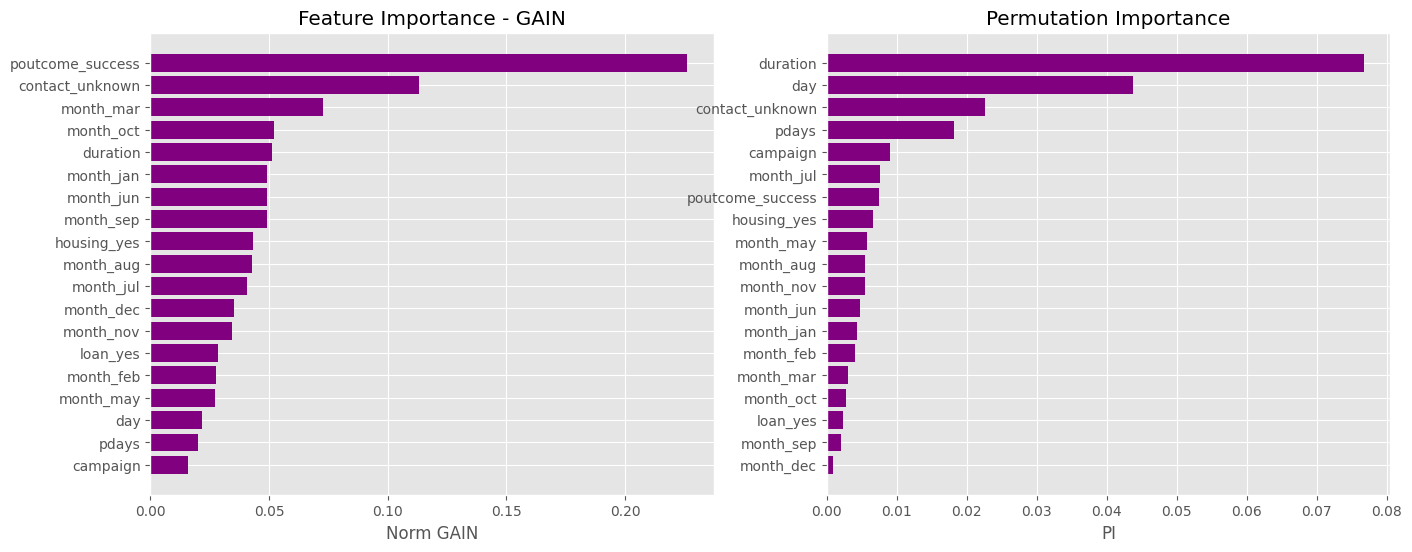

In [750]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fi_plot(X_train_cham.columns, model_cham.feature_importances_, title_text = "Feature Importance - GAIN",
        yaxis_text = 'Norm GAIN', ax = ax1)
pi_results_train = permutation_importance(model_cham, X_train_cham, y_train, n_repeats = 10, random_state = 0).importances_mean
fi_plot(X_train_cham.columns, pi_results_train, title_text = "Permutation Importance",
        yaxis_text = 'PI', ax = ax2)

Widzimy, iż liczba zmiennych w rozważanym modelu została skutecznie zredukowana do 19. Widzimy, iż jednymi z najważniejszych cech są **duration** (czas trwania ostatniego kontaktu), **contact_unknown** (nieznany typ kontaktu) oraz **poutcome_success** (sukces w poprzedniej kampanii). Z kolei zmienne, które miały bardzo niewielki wpływ na model, zostały skutecznie usunięte. Możemy zauważyć, że zredukowanie liczby cech w modelu skutecznie ograniczyło jego złożoność i zredukowało szum informacyjny.

Dla modelu z usuniętymi zmiennymi przeprowadzę teraz **optymalizację hiperparametrów** (na podstawie tych dla modelu4), by zwiększyć jego skuteczność, a następnie obliczę dla niego wartości GINI zarówno dla zbioru treningowego, jak i dla zbioru testowego. Wyniki przedstawię w łączonej tabeli.

In [753]:
best_params_2 = grid_search2.best_params_
model_champion = xgb.XGBClassifier(**best_params_2)
model_champion.fit(X_train_cham, y_train)

model_results = pd.concat([model_results,
                           model_summary(model_champion, 'model_champion', 
                                         'model z usuniętymi zmiennymi ze zoptymalizowanymi parametrami',
                                         X_train_cham, X_test_cham, y_train, y_test)])

pd.set_option('display.max_colwidth', None) 
model_results

,Nazwa modelu,Opis,Liczba zmiennych,Gini TRAIN,Gini TEST
0,model1,model o domyślnych hiperparametrach,16,96.024070,86.911006
0,model3,model ze zoptymalizowanymi parametrami dla standardowego zbioru treningowego,16,93.269554,87.855102
0,model2,model na domyślnych hiperparametrach ze zmiennymi dummy,42,95.659106,87.722538
0,model4,model ze zoptymalizowanymi parametrami dla zmiennych dummy,42,91.090316,87.983486
0,model_cham,model z usuniętymi zmiennymi,19,93.591606,87.702411
0,model_champion,model z usuniętymi zmiennymi ze zoptymalizowanymi parametrami,19,89.614951,88.178521


## NAJLEPSZY MODEL - MODEL CHAMPION

**Najlepszym modelem okazał się model ostatni - model_champion**, czyli model ze zmiennymi typu dummy, z usuniętymi zbędnymi cechami oraz ze zoptymalizowanymi hiperparametrami. Model ten osiąga **najwyższą wartość GINI dla zbioru testowego** spośród wszystkich modeli. Oznacza to, że najlepiej generalizuje on na nowych danych, co jest kluczowe w praktycznych zastosowaniach. Model ten jest również **najbardziej stabilny** i **nieprzeuczony**, gdyż różnica między GINI dla zbiorów treningowego i testowego jest niewielka. Ponadto, owy model_champion, mimo najlepszej skuteczności, **korzysta z zaledwie 19 cech**, co oznacza mniejszą złożoność, szybsze działanie i łatwiejszą interpretację. Zatem, to ten model jest najlepszy spośród wszystkich rozważonych - wygrywa nie tylko skutecznością, ale też stabilnością i prostotą.

## ANALIZA JAKOŚCI MODELU CHAMPION

**Miara GINI:**

Wiemy już, że wartość GINI wybranego najlepszego modelu wynosi: **89.614951	dla zbioru treningowego oraz 88.178521 dla zbioru testowego**. Są to bardzo wysokie wartości, a różnica między nimi jest niewielka, co wskazuje na brak przeuczenia. Model ten bardzo dobrze generalizuje na nowe, niewidziane wcześniej dane, gdyż osiąga najwyższą wartość GINI dla zbioru testowego.

Przedstawię teraz **wykresy funkcji ROC** dla modelu_champion zarówno dla zbioru treningowego, jak i dla zbioru testowego.

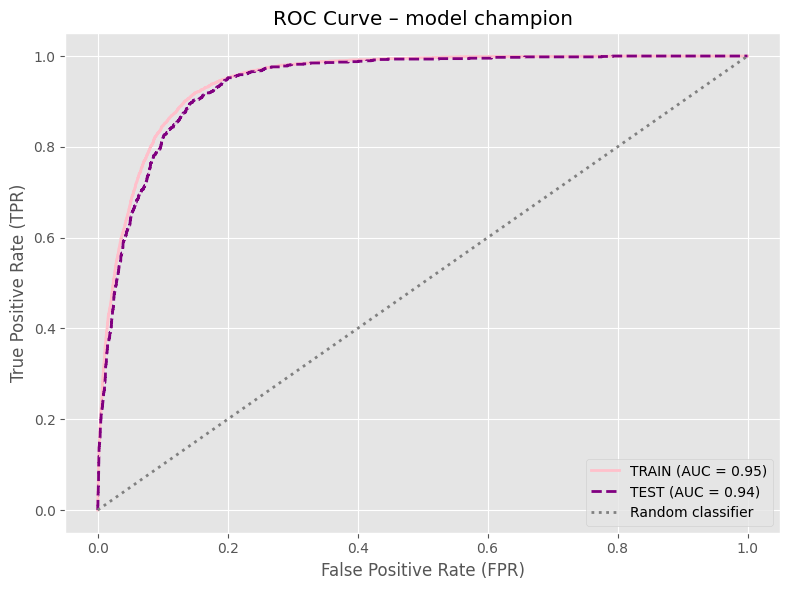

In [757]:
plot_roc_curve_for_model(model_champion, X_train_cham, y_train, X_test_cham, y_test, model_name='model champion')

Widzimy, iż obie przedstawione wartości AUC są bardzo wysokie. W porównaniu do modelu1, wartość AUC dla zbioru treningowego spadła, ale dla zbioru testowego jest ona większa. Ponadto, w tym przypadku krzywe ROC są do siebie bardziej zbliżone, co wskazuje na lepsze dopasowanie modelu_champion i brak przeuczenia - w przeciwieństwie do modelu1. Możemy również zauważyć, że otrzymane krzywe ROC leżą blisko prawego górnego rogu, co oznacza, że model osiąga wysokie wartości czułości przy niskiej liczbie fałszywych alarmów.

**Miary jakości zmiennych**

**Feature Importance - GAIN:**

Przedstawię teraz wykres znormalizowanej miary ważności cech (feature importance) dla rozważanego modelu - modelu_champion - opartą na metryce GAIN.

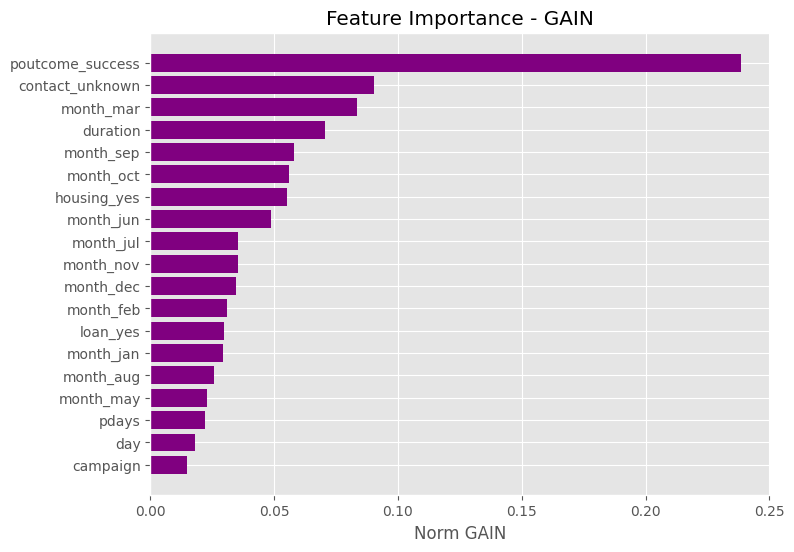

In [759]:
fi_plot(X_train_cham.columns, model_champion.feature_importances_, title_text = "Feature Importance - GAIN",
        yaxis_text = 'Norm GAIN')

Widzimy, iż najważniejszą cechą okazuje się być **poutcome_success** (sukces w poprzedniej kampanii) - jest to najsilniejsza predykcyjnie zmienna. Również bardzo istotnymi zmiennymi są **contact_unknown** (nieznany typ kontaktu), **month_mar** (marzec jako miesiąc ostatniego kontaktu) i **duration** (czas trwania ostatniego kontaktu). Są to cechy, które najbardziej przyczyniają się do dobrych prognoz modelu. Z kolei najmniej ważne zmienne to **campaign** (liczba kontaktów w tej kampanii), **day** (dzień ostatniego kontaktu) i **pdays** (liczba dni od ostatniego kontaktu). Są to cechy, których wpływ na decyzję modelu jest najmniejszy, ale jeszcze uzasadniony, skoro pozostały one po selekcji zmiennych w modelu_champion - są to zmienne uzupełniające kontekst, ale nie kluczowe. Ponadto, wykres ten potwierdza, że wybrany najlepszy model korzysta z logicznych, silnych predyktorów, a cechy zostały dobrze wyselekcjonowane - brak szumu informacyjnego.

**Permutation Importance:**

Przedstawię teraz wartości miary Permutation Importance na wykresach zarówno dla zbioru treningowego, jak i dla zbioru testowego dla rozważanego modelu_champion.

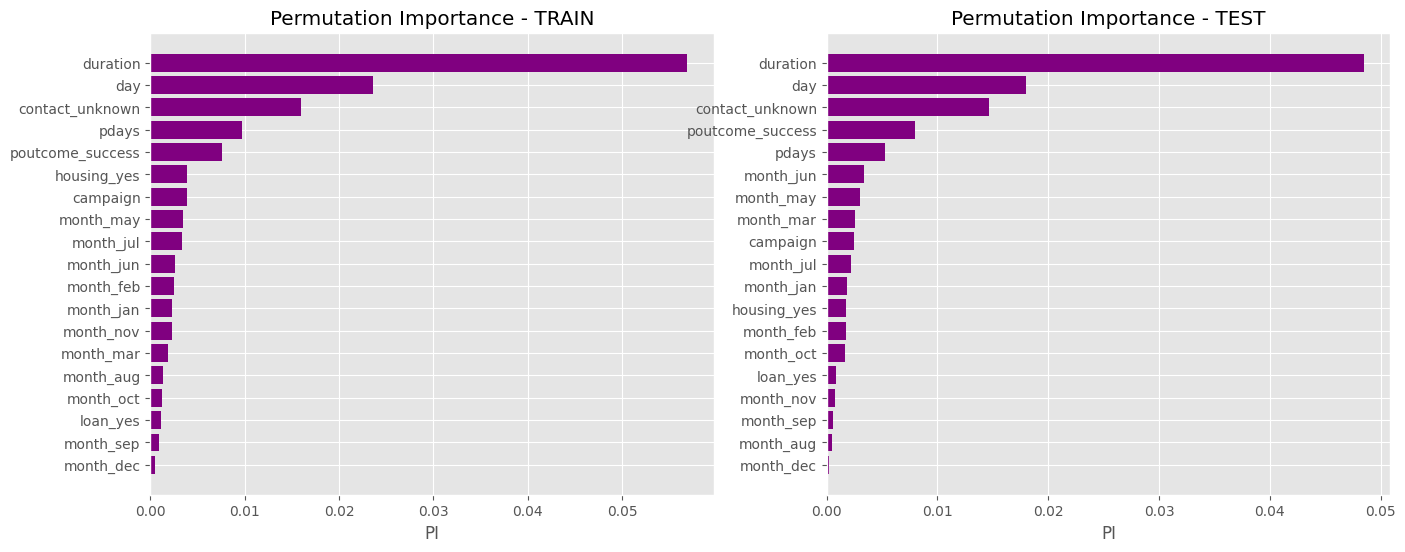

In [763]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
pi_results_train = permutation_importance(model_champion, X_train_cham, y_train, n_repeats = 10, random_state = 0).importances_mean
pi_results_test = permutation_importance(model_champion, X_test_cham, y_test, n_repeats = 10, random_state = 0).importances_mean

fi_plot(X_train_cham.columns, pi_results_train, title_text = "Permutation Importance - TRAIN",
        yaxis_text = 'PI', ax = ax1)
fi_plot(X_train_cham.columns, pi_results_test, title_text = "Permutation Importance - TEST",
        yaxis_text = 'PI', ax = ax2)

Widzimy, iż otrzymane wykresy miary Permutation Importance dla zbiorów treningowego i testowego są zbliżone do siebie - mają podobną strukturę oraz analogiczne zmienne uznają za najważniejsze. Pokazuje to, że uzyskany model jest w miarę stabilny oraz nieprzeuczony. Występują pewne różnice, ale są one niewielkie. Ponadto, możemy zauważyć, że miara ta za najważniejsze zmienne uznała **duration** (czas trwania ostatniego kontaktu), **day** (dzień ostatniego kontaktu) oraz **contact_unknown** (nieznany typ kontaktu). Z kolei za najmniej ważną uznała cechę **month_dec** (grudzień jako miesiąc ostatniego kontaktu). Widzimy jednak, że zredukowanie liczby zmiennych w modelu_champion spowodowało ograniczenie szumu informacyjnego w modelu oraz wyeliminowanie takich zmiennych, które praktycznie nie mają wpływu na uzyskiwaną moc. 

**SHAP:**

Przedstawię teraz wykresy SHAP zarówno dla zbioru treningowego, jak i dla zbioru testowego rozważanego modelu_champion.

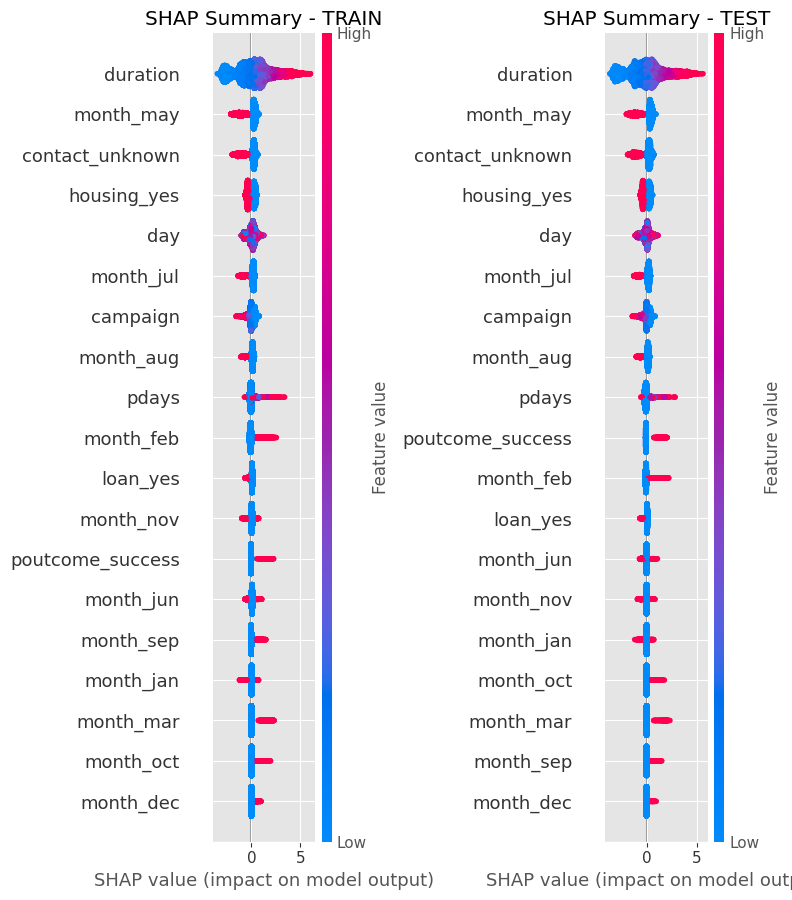

In [769]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

with suppress_output():
    plt.sca(ax1)
    explainer = shap.TreeExplainer(model_champion, X_train_cham)
    shap_values = explainer.shap_values(X_train_cham)
    shap.summary_plot(shap_values, X_train_cham, show=False)
    ax1.set_title('SHAP Summary - TRAIN')
    
    plt.sca(ax2)
    explainer2 = shap.TreeExplainer(model_champion, X_test_cham)
    shap_values2 = explainer2.shap_values(X_test_cham)
    shap.summary_plot(shap_values2, X_test_cham, show=False)
    ax2.set_title('SHAP Summary - TEST')
    
    plt.tight_layout()
    plt.show()

Ponownie widzimy, iż struktura otrzymanych wykresów dla zbiorów treningowego i testowego jest bardzo zbliżona. Na obu tych wykresach widać, że to zmienne **duration** (czas trwania ostatniego kontaktu), **month_may** (maj jako miesiąc ostatniego kontaktu) i **contact_unknown** (nieznany typ kontaktu) są najważniejsze w badanym modelu. Z kolei zmmienna **month_dec** (grudzień jako miesiąc ostatniego kontaktu) jest najmniej ważna. Możemy ponadto zauważyć, że (dla zmiennej **duration**) im dłuższy czas trwania rozmowy telefonicznej, tym bardziej prawdopodobne jest, że klient zdecyduje się na lokatę - rozkład pokazuje, że to ta zmienna ma największy i najbardziej zróżnicowany wpływ. Możemy także zauważyć, że (dla zmiennej **pdays**) im większa liczba dni od ostatniego kontaktu z klientem, tym większe prawdopodobieństwo, że klient udzieli zgodę na lokatę.

***

W raporcie tym zobaczyliśmy, w jaki sposób można poprawić moc danego modelu - czy to poprzez optymalizację hiperparametrów, czy to poprzez użycie zmiennych typu dummy. Przetestowaliśmy wiele sposób na ulepszenie modelu i wybraliśmy ten model, który okazał się być najskuteczniejszy - **model_champion**. Następnie, przeprowadziliśmy analizę jakości tego modelu, aby zobrazować jego skuteczność pod względem różnych miar.